# Emissions Calculation Methodology

##### Step 1: Determine the operating mode of the vessel at each AIS data point

GPS Speed provides movement activity which can be used to categorize vessels as either moving or stationary. 

There are four operating modes:
* Transit: If speed > 1 OR navigational status = 0, 3, 4, 8, 11, 12 (considered 'moving' statuses) and it's OUTSIDE the maneuvering zone but inside the bigger port fence.
* Anchorage: The vessel must be at an anchorage and non-moving (speed <1).
* Maneuvering: If speed > 1 or navigational status = 0, 3, 4, 8, 11, 12 (considered 'moving' statuses) and it's INSIDE the maneuvering zone.
* Alongside/Hotel: The vessel must be berthed (within a berth polygon) and speed <1. Note: If speed is > 1, the mode is either transit or manoeuvre.
When determining moving vessels, either speed or navigation status can be used.

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv("vessel_movements/vessel_movements_PPT.csv")
df.head()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

ppt_path = 'PPT_shapefiles/'

fig, ax = plt.subplots(figsize=(10, 10))

colors = ['blue', 'green', 'red', 'yellow']
labels = ['PPT Anchorage', 'PPT Berths', 'PPT Port Boundary', 'PPT Maneuvering Zone']

alpha_level = 0.5

for i, shp_name in enumerate(['PPT_anchorage.shp', 'PPT_berths.shp', 'PPT_portboundary.shp', 'PPT_maneuveringzone.shp']):
# for i, shp_name in enumerate(['PPT_portboundary.shp']):
    shp_file = ppt_path + shp_name
    data = gpd.read_file(shp_file)
    data.plot(ax=ax, color=colors[i], alpha=alpha_level, label=labels[i])

legend_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]
plt.legend(handles=legend_patches)

ax.set_title('Combined Shapefile Plot')
plt.show()


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

csv_file = "vessel_movements/vessel_movements_PPT.csv"
df = pd.read_csv(csv_file)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

ppt_path = 'PPT_shapefiles/'
shp_file = ppt_path + 'PPT_portboundary.shp'
port_boundary = gpd.read_file(shp_file)

points_within_boundary = gpd.sjoin(gdf, port_boundary, how="left", op='within')

df['is_within_port_boundary'] = points_within_boundary['index_right'].notna()

df.to_csv('vessel_movements/updated_vessel_movements_PPT.csv', index=False)


In [ ]:
import pandas as pd

csv_file = 'vessel_movements/updated_vessel_movements_PPT.csv'
df = pd.read_csv(csv_file)

value_counts = df['is_within_port_boundary'].value_counts()

print(value_counts)


In [5]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

ppt_path = 'PPT_shapefiles/'
csv_file = "vessel_movements/vessel_movements_PPT.csv"
df = pd.read_csv(csv_file)
print(df.shape)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

# port
shp_file = ppt_path + 'PPT_portboundary.shp'
port_boundary = gpd.read_file(shp_file)
points_within_boundary = gpd.sjoin(gdf, port_boundary, how="left", op='within')
df['is_within_port_boundary'] = points_within_boundary['index_right'].notna()

# maneuveringzone
shp_file = ppt_path + 'PPT_maneuveringzone.shp'
port_boundary = gpd.read_file(shp_file)
points_within_boundary = gpd.sjoin(gdf, port_boundary, how="left", op='within')
df['is_within_maneuveringzone_boundary'] = points_within_boundary['index_right'].notna()

# anchorage
shp_file = ppt_path + 'PPT_anchorage.shp'
port_boundary = gpd.read_file(shp_file)
points_within_boundary = gpd.sjoin(gdf, port_boundary, how="left", op='within')
df['is_within_anchorage_boundary'] = points_within_boundary['index_right'].notna()

# berths
shp_file = ppt_path + 'PPT_berths.shp'
port_boundary = gpd.read_file(shp_file)
points_within_boundary = gpd.sjoin(gdf, port_boundary, how="left", op='within')
df['is_within_berths_boundary'] = points_within_boundary['index_right'].notna()

# df.to_csv('vessel_movements/vessel_movements_PPT_boundary.csv', index=False)
print(df.shape)



(2822599, 32)


/Users/yitong/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/mw/ndw5s15176bcd42tvgdm8lg00000gn/T/ipykernel_86344/3708791790.py:14: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  points_within_boundary = gpd.sjoin(gdf, port_boundary, how="left", op='within')
/Users/yitong/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/mw/ndw5s15176bcd42tvgdm8lg00000gn

(2822599, 36)


In [6]:
def operating_modes(lon, lat, speed, nav_stat, is_within_port_boundary, is_within_maneuveringzone_boundary, is_within_anchorage_boundary, is_within_berths_boundary):
    if speed > 1 and nav_stat in [0, 3, 4, 8, 11, 12] and not is_within_maneuveringzone_boundary and is_within_port_boundary:
        return "Transit"
    elif is_within_anchorage_boundary and speed < 1:
        return "Anchorage"
    elif speed < 1 and nav_stat in [0, 3, 4, 8, 11, 12] and is_within_maneuveringzone_boundary:
        return "Maneuvering"
    elif is_within_berths_boundary and speed < 1:
        return "Alongside/Hotel"
    else:
        return "Other"

df['mode'] = df.apply(lambda row: operating_modes(row['lon'], row['lat'], row['speed'], row['nav_stat'], 
                                                  row["is_within_port_boundary"], row["is_within_maneuveringzone_boundary"], 
                                                  row["is_within_anchorage_boundary"], row["is_within_berths_boundary"]), axis=1)
df = df[df['mode'] != 'Other']
df.to_csv('modified_csv_file.csv', index=False)

print(df.shape)

(2492968, 37)


In [21]:
df = pd.read_csv('modified_csv_file.csv')

In [22]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.sort_values(by=['imo', 'timestamp'])
df['time_diff'] = df.groupby('imo')['timestamp'].diff().dt.total_seconds()

# Identify non-continuous events
# If the time difference is greater than 10,000 seconds, we treat it as a new event
df['is_continuous'] = df['time_diff'] <= 10000

# Handle the non-continuous events by setting the time_diff to NaN or another identifier
df.loc[~df['is_continuous'], 'time_diff'] = None

In [23]:
df = df[df['mode'] == 'Alongside/Hotel']
df.shape

(861716, 39)

In [24]:
df.to_csv("test.csv", index=False)

In [26]:
df = pd.read_csv('test.csv')

df = df[df['mode'] == 'Alongside/Hotel']

# Check if 'time_diff' and 'ael' columns exist
if 'time_diff' in df.columns and 'ael' in df.columns:
    # Multiply 'time_diff' and 'ael', then sum the results
    total_product = (df['time_diff'] * df['ael']).sum()

    # Sum of 'time_diff'
    total_time_diff = df['time_diff'].sum()

    # Calculate the final result
    result = total_product / total_time_diff if total_time_diff != 0 else 0

    print("Result:", result)
else:
    print("Error: CSV file must contain 'time_diff' and 'ael' columns.")


Result: 899.2943510342932


DayEL: 885.746345832815
NightEL: 905.9965766732915


/var/folders/mw/ndw5s15176bcd42tvgdm8lg00000gn/T/ipykernel_86344/1755654952.py:15: RuntimeWarning: invalid value encountered in scalar divide
  return (group['ael'] * group['time_diff']).sum() / group['time_diff'].sum()


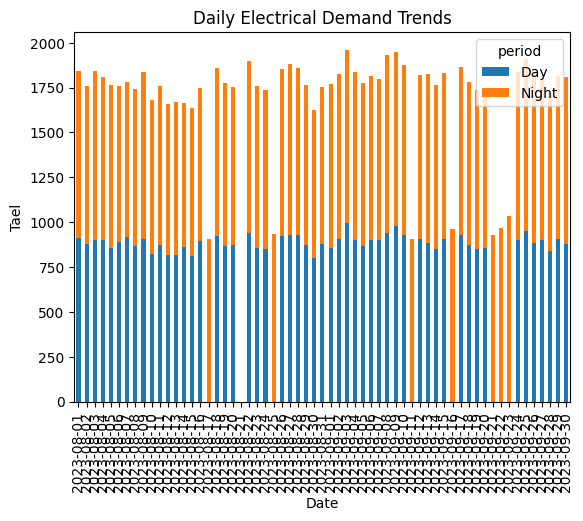

/var/folders/mw/ndw5s15176bcd42tvgdm8lg00000gn/T/ipykernel_86344/1755654952.py:39: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['timestamp'].dt.to_period('M')


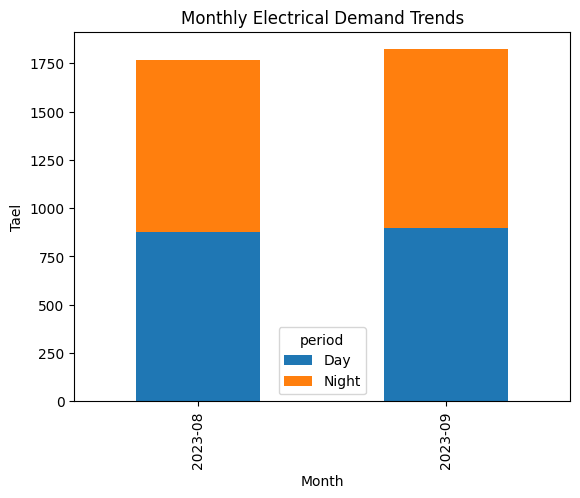

In [32]:
# Load demand variation from the grid through day and night on a monthly basis
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
df = pd.read_csv('test.csv')


# Step 2: Parse Timestamps and Identify Day/Night
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['period'] = df['hour'].apply(lambda x: 'Day' if 9 <= x < 17 else 'Night')

# Step 3: Calculate 'DayEL' and 'NightEL'
def calculate_tael(group):
    return (group['ael'] * group['time_diff']).sum() / group['time_diff'].sum()

# Calculating DayEL and NightEL separately
day_data = df[df['period'] == 'Day']
night_data = df[df['period'] == 'Night']

day_el = calculate_tael(day_data) if not day_data.empty else 0
night_el = calculate_tael(night_data) if not night_data.empty else 0

# Printing DayEL and NightEL results
print(f"DayEL: {day_el}")
print(f"NightEL: {night_el}")

# Step 4: Visualize Trends
# Daily Trends
df['date'] = df['timestamp'].dt.date
daily_trends = df.groupby(['date', 'period']).apply(calculate_tael).unstack().fillna(0)
daily_trends.plot(kind='bar', stacked=True)
plt.title('Daily Electrical Demand Trends')
plt.xlabel('Date')
plt.ylabel('Tael')
plt.show()

# Monthly Trends
df['month'] = df['timestamp'].dt.to_period('M')
monthly_trends = df.groupby(['month', 'period']).apply(calculate_tael).unstack().fillna(0)
monthly_trends.plot(kind='bar', stacked=True)
plt.title('Monthly Electrical Demand Trends')
plt.xlabel('Month')
plt.ylabel('Tael')
plt.show()


In [ ]:
# too slow, useless
# dont use this one
df = pd.read_csv('vessel_movements/vessel_movements_PPT.csv')
print(df.shape)

import geopandas as gpd
from shapely.geometry import Point

def is_within_zone(lon, lat, shp_path):
    maneuvering_zone = gpd.read_file(shp_path)
    point = Point(lon, lat)
    return any(point.within(polygon) for polygon in maneuvering_zone.geometry)

shp_path = 'PPT_shapefiles/PPT_maneuveringzone.shp'

    
def operating_modes(lon, lat, speed, nav_stat):
    if speed > 1 and nav_stat in [0, 3, 4, 8, 11, 12] and not is_within_zone(lon, lat, 'PPT_shapefiles/PPT_maneuveringzone.shp') and is_within_zone(lon, lat, 'PPT_shapefiles/PPT_portboundary.shp'):
        return "Transit"
    elif is_within_zone(lon, lat, "PPT_shapefiles/PPT_anchorage.shp") and speed < 1:
        return "Anchorage"
    elif speed < 1 and nav_stat in [0, 3, 4, 8, 11, 12] and is_within_zone(lon, lat, "PPT_shapefiles/PPT_maneuveringzone.shp"):
        return "Maneuvering"
    elif is_within_zone(lon, lat, 'PPT_shapefiles/PPT_berths.shp') and speed < 1:
        return "Alongside/Hotel"
    else:
        return "Other"

df['mode'] = df.apply(lambda row: operating_modes(row['lon'], row['lat'], row['speed'], row['nav_stat']), axis=1)
df = df[df['mode'] != 'Others']
df.to_csv('modified_csv_file.csv', index=False)



In [ ]:
import pandas as pd

def calculate_total_electrical_load(ael_values, duration_hours):
    """
    Calculate the total electrical demand from ship in alongside mode (Tael).

    Args:
    ael_values (list of float): List of Auxiliary engine loads (ael) in kW.
    duration_hours (list of float): List of durations in hours the ship is alongside.

    Returns:
    float: The total electrical demand from ship in alongside mode (Tael).
    """
    if len(ael_values) != len(duration_hours):
        raise ValueError("The length of ael_values and duration_hours must be the same.")

    total_product = sum(ael * hours for ael, hours in zip(ael_values, duration_hours))
    total_duration = sum(duration_hours)

    if total_duration == 0:
        raise ValueError("Total duration cannot be zero.")

    tael = total_product / total_duration
    return tael

def calculate_total_electrical_load_from_csv(df):
    """
    Calculate the total electrical demand from ship in alongside mode (Tael) from a CSV file,
    skipping any rows where 'duration_hours' is NaN.

    Args:
    file_path (str): Path to the CSV file containing 'ael' and 'duration_hours' columns.

    Returns:
    float: The total electrical demand from ship in alongside mode (Tael).
    """
    data = df

    # Ensure the necessary columns are present
    if 'ael' not in data.columns or 'duration_hours' not in data.columns:
        raise ValueError("CSV file must contain 'ael' and 'duration_hours' columns.")

    # Filter out rows where 'duration_hours' is NaN
    filtered_data = data.dropna(subset=['duration_hours'])

    # Extract the columns
    ael_values = filtered_data['ael']
    duration_hours = filtered_data['duration_hours']

    # Calculate Tael using the previously defined function
    return calculate_total_electrical_load(ael_values, duration_hours)

# Example usage (replace 'your_file.csv' with the path to your actual CSV file)
# file_path = 'your_file.csv'
# tael = calculate_total_electrical_load_from_csv(file_path)
# print(tael)


##### Step 2: Log events at each timestamp

The event duration is the difference between two consecutive timestamps for each vessel i.e. same IMO number. 

Note: If the difference between two AIS time stamps is more than 10,000 seconds, then the event is not continuous and should not undergo calculation for this greater than 24-hour period. Thereafter it should start afresh.


##### Step 3: Determine the vessel type

Determine if the vessel is an Ocean Going Vessel (OGV, of below types) or a different type.

1. Bulk carrier - cargo vessel for the carriage of dry bulk cargo
2. Container ship – cargo vessel for the carriage of containerized goods
3. General cargo – cargo vessel for the carriage of various types of dry cargo
4. LPG / Anhydrous ammonia tanker – cargo vessel for the bulk carriage of liquefied petroleum gas or ammonia
5. Passenger / Cruise ship - vessels for the carriage of passengers.
6. Product tanker – cargo vessel for the carriage of refined oil products carried in bulk
7. Reefer ship - special form of cargo ship. It is used to transport goods that must remain refrigerated during the entire transport or where the cold chain must not be interrupted
8. Ro-ro ship – cargo vessel for the carriage of wheeled cargo
9. Chemical Tankers - cargo vessels for the carriage of Chemicals

NOTE: LNG Tankers are to be excluded


##### Step 4: Determine Emissions Tier

For OGVs, identify its Emissions Tier using Model Year (derived from the vessel's build date).

##### Step 5: Determine Fuel Category

Ports have defined fuel categories (e.g. High Sulphur, Global 0.5%, ECA). 

For 2023, Singapore will fall under Global 2020.

##### Step 6: Retrieve specific ship details for all vessels that are within the port boundary

1. Main engine SFC (sfc_me)
2. Aux engine SFC (sfc_ae)
3. Auxiliary Boiler SFC (sfc_ab) 


##### Step 7: Calculate Emissions

This step is dependent on the previous steps. Refer to below explanation for emission calculations

Note: 
* Sequence to be strictly followed for calculations
* Emissions do not need to be calculated for data points with missing parameters (e.g. p, speed, ael, abl, sfc_me, sfc_ae) and can be zero as default, where these parameters are used in calculation formulas. 
* If the missing parameters are not used in the calculation formula (e.g. for calculating emissions in alongside mode), there should be emissions.





###### Step 7a: Get the following parameters from the vessel movements data:

* p
* Reference speed (vref)
* Actual speed (AS)


###### Step 7b: Calculate maximum speed

Formula:

>Maximum Speed (MS) = 1.066 x vref

###### Step 7c: Get activity hours (A) for each operating mode

This was calculated in Step 2. 


###### Step 7d (i): Calculate Engine Load Factor (LF) for propulsion engines

 >\\(LF =(AS/MS){^3}\\)
<br>Where</br> 
  LF = Load Factor
  <br>AS =  Actual speed (knots)</br>
    MS = Maximum speed (knots)

###### Step 7d(ii): Look up Low Load Adjustment Factor (LLAF) using LF calculated in Step 7d(i)

* Refer to llaf_table
* LLAF is not applicable if LF is more than 0.2. LLAF will be 1 in such cases.


###### Note: Propulsion engine emission can only be calculated for transit and maneuver modes since at other times the main engine is not running.

###### Step 7e: If LF < 0.2 and mode is transit or maneuver, then LF will be defaulted to 0 .2.
Note: this default is not applied when identifying LLAF


###### Step 7f: Emission factor (EF) table is provided.  Singapore is a non-Emission Controlled Area (ECA) so Global 2020 rows are applicable. The EF table has some formulas applied for certain pollutants:
<br>
1. NOx

* Refer to tables Propulsion Engine Emission Factors and Auxiliary Engine Emission Factors for main engine and auxiliary engine. The values used are dependent on Engine Type and Emissions Tier in vessel movements table.

* Do the same for Auxiliary Boiler (Boiler Engine Emission Factors table).

2. PM10 will be calculated as follows:
* Main Engine and Auxiliary Engine = 0.23 + (sfc_me or sfc_ae ) x 7 x 0.02247 x (0.005-0.0024)
* Boiler = direct look up to Boiler Engine Emission Factors table

3. PM2.5 = 0.92 x PM10

4. VOC = direct look up EngineType column in vessel movements table.

5. SOx – Refer to vessel movements table.
* For Main Engine= sfc_me x 2 x 0.97753 x 0.005
* For Auxiliary engine= sfc_ae x 2 x 0.97753 x 0.005
* For Auxiliary Boiler= sfc_ab x 2 x 0.97753 x 0.005

6. CO2 - Refer to vessel movements table
* For Main Engine= sfc_me x 0.867 x 3.667
* For Auxiliary engine= sfc_ae x 0.867 x 3.667
* For Auxiliary Boiler= sfc_ab x 0.867 x 3.667

7. CH4 - Refer to vessel movements table
* For Main Engine and Auxiliary Boiler = corresponding direct look up Propulsion Engine Emission Factors and Auxiliary Engine Emission Factors with reference to Columns EngineType and EmissionsTier
* For Aux engine = Dependent on Auxiliary engine load (Column ael) and EmissionsTier, direct look-up

8. N2O – EngineType and EmissionsTier, dependent look up


###### Step 7g:	Based on above identifications, the formulae below will be used to get the final results.

The emission factor is in terms of emissions per unit of energy from the engine. It is multiplied by the energy consumed while in each mode.
<br></br>
Propulsion engine emissions for each mode are calculated according to the general equation:
<br></br>
>E = P x LF x A x EF x LLAF
<br></br>
Where
<br>E = Emissions (grams [g])</br>
P = Maximum Continuous Rating (MCR) Power for propulsion engines (kilowatts [kW]) 
<br>LF = Load Factor (percent of vessel's total power)</br>
A = Activity (hours [h]) (hours/call)
<br>EF = Emission Factor (grams per kilowatt-hour [g/kWh])</br>
LLAF = Low Load Adjustment Factor for when the load factor is below 20%.

Auxiliary engine emissions are calculated according to the general equation:
<br></br>
>E = LA X A x EF
<br></br>
Where
<br>E = Emissions (grams [g])</br>
\\(L{_A}\\) = Auxiliary engine load (kW)
<br>A = Activity (hours [h]) (hours/call)</br>
EF = Emission Factor (grams per kilowatt-hour [g/kWh])
<br></br>

Auxiliary boiler emissions are calculated using the general equation below:
<br></br>
>E = LB X A x EF
<br></br>
Where
<br>E = Emissions (grams [g])</br>
\\(L{_B}\\) = Boiler Load (kW),
<br>A = Activity (hours [h]) (hours/call)</br>
EF = Emission Factor (grams per kilowatt-hour [g/kWh])

###### Step 7h:	In vessel movements data, identify the below:

\\(L{_A}\\) = Auxiliary Engine load (Column ael)
<br>
\\(L{_B}\\) = Auxiliary Boiler load (Column abl)

#####Note: 
*Total emissions of a certain pollutant type = Sum of emissions from Main Engine, Auxiliary engine and Auxiliary Boiler

*Focus is not calculation of any other pollutants outside this discussion.
<br></br>


#### Total Electrical Load Analysis

Alongside or hotel load is the electrical load when the vessel is at the terminal/berth. In this mode the Main Engine is off since the Propulsion is not happening. Auxiliary Engines are running since they need to supply the electrical load for the ship and loading/discharging operating machineries.
<br></br>
Auxiliary Boilers produce steam and hence cannot be plugged into the electrical grid and there is no machinery onboard to generate steam.
<br></br>
Hence, for the purpose of this scope the Auxiliary engine load (column ael) in alongside mode will be used to identify the electrical load demand of the ships.
<br></br>
Total electrical demand from ship in alongside mode (Tael) = time-weighted average electrical load (ael) in alongside mode = (Sum of Product of Ael multiplied by alongside duration hours) divide by (Sum of total alongside duration in hours).


#### Load demand variation from the grid through day and night on a monthly basis

1. For each “Alongside” operation mode, identify the time of the day as per below definition of Day and Night from timestamp column in vessel movements table.
* Day = 0900 to 1700 hours
* Night = 1700 to 0900 hours
2. Create visualizations to analyze the trends of the daily and monthly demand on the shore supply grid.
3. For DayEL and NightEL results, use the formula provided in previous section for the associated time description stated above.
<br></br>
NOTE: This day/ night demand can vary significantly depending on the weather and time of year in many parts of the world if not so much in Singapore. Example, winter may lead to smaller daylight time and hence more demand for vessel’s external lights to be on and vice versa. 

